<a href="https://colab.research.google.com/github/SanyiBet/datasets/blob/main/NLP_CajamarcaSanyi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de Emociones en Tweets - Dataset EmoEvent
## Análisis Exploratorio de 3 Modelos para Clasificación de Emociones
## Estudiante: Cajamarca Sanyi

# Instalación de Dependencias

In [95]:
!pip install transformers torch scikit-learn pandas numpy matplotlib seaborn wordcloud
!pip install datasets accelerate evaluate requests

# Función para descargar archivos directamente desde GitHub
import requests
import os
import pandas as pd

def download_file(url, filename):
    """Descarga un archivo desde una URL"""
    try:
        response = requests.get(url)
        response.raise_for_status()

        # Crear directorio si no existe
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Descargado: {filename}")
        return True
    except Exception as e:
        print(f"Error descargando {filename}: {e}")
        return False

# URLs de los archivos en GitHub (estructura correcta)
base_url = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/en/"
files_to_download = {
    'train.tsv': base_url + 'train.tsv',
    'dev.tsv': base_url + 'dev.tsv',
    'test.tsv': base_url + 'test.tsv'
}

# Verificar si ya existe el directorio o crearlo
if not os.path.exists('EmoEvent/splits/en'):
    print("Creando directorio para datos...")
    os.makedirs('EmoEvent/splits/en', exist_ok=True)

# Descargar archivos si no existen
for filename, url in files_to_download.items():
    filepath = f'EmoEvent/splits/en/{filename}'
    if not os.path.exists(filepath):
        print(f"Descargando {filename}...")
        success = download_file(url, filepath)
        if not success:
            print(f"Fallo al descargar {filename}")
    else:
        print(f"{filename} ya existe")

# También intentar descargar el CSV como respaldo
csv_url = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/emoevent_en.csv"
csv_filepath = "EmoEvent/emoevent_en.csv"
if not os.path.exists(csv_filepath):
    print("Descargando archivo CSV de respaldo...")
    download_file(csv_url, csv_filepath)

# Verificar archivos descargados
print("\nArchivos en el directorio:")
if os.path.exists('EmoEvent/splits/en'):
    for file in os.listdir('EmoEvent/splits/en'):
        filepath = f'EmoEvent/splits/en/{file}'
        size = os.path.getsize(filepath) if os.path.exists(filepath) else 0
        print(f"  {file}: {size} bytes")

if os.path.exists('EmoEvent/emoevent_en.csv'):
    size = os.path.getsize('EmoEvent/emoevent_en.csv')
    print(f"  emoevent_en.csv: {size} bytes")

train.tsv ya existe
dev.tsv ya existe
test.tsv ya existe

Archivos en el directorio:
  dev.tsv: 164881 bytes
  .DS_Store: 6148 bytes
  test.tsv: 319042 bytes
  train.tsv: 1126126 bytes
  emoevent_en.csv: 1123495 bytes


#Importación de Librerías

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, pipeline
)
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
plt.style.use('ggplot')
sns.set_palette("husl")

# 1. Carga y Exploración del Dataset



In [97]:
# Cargar los datos
def load_data():
    """Carga los datos del dataset EmoEvent desde los archivos TSV"""
    import os

    base_path = 'EmoEvent/splits/en/'

    # Esta es la parte corregida. Forzamos a que no use el encabezado
    # y asignamos los nombres de las columnas directamente.
    try:
        train_df = pd.read_csv(base_path + 'train.tsv', sep='\t', header=None,
                              names=['tweet', 'event', 'emotion'])
        dev_df = pd.read_csv(base_path + 'dev.tsv', sep='\t', header=None,
                            names=['tweet', 'event', 'emotion'])
        test_df = pd.read_csv(base_path + 'test.tsv', sep='\t', header=None,
                             names=['tweet', 'event', 'emotion'])

        print("Datos cargados exitosamente desde archivos TSV")
        return train_df, dev_df, test_df

    except Exception as e:
        print(f"Error cargando archivos TSV: {e}")
        # Si falla, se puede intentar la carga desde el CSV de respaldo
        csv_path = 'EmoEvent/emoevent_en.csv'
        if os.path.exists(csv_path):
            print(f"Cargando desde {csv_path} como respaldo...")
            df = pd.read_csv(csv_path)
            # ... (el resto de tu código de respaldo aquí)

        raise FileNotFoundError("No se pudieron cargar los datos desde ninguna fuente.")

try:
    train_df, dev_df, test_df = load_data()

    # Combinar train y dev para un conjunto de entrenamiento más grande
    full_train_df = pd.concat([train_df, dev_df], ignore_index=True)

    print(f"\nDATOS CARGADOS EXITOSAMENTE:")
    print(f"Tamaño del conjunto de entrenamiento: {len(full_train_df)}")
    print(f"Tamaño del conjunto de prueba: {len(test_df)}")
    print(f"Total de tweets: {len(full_train_df) + len(test_df)}")

    # Mostrar primeras filas para verificar formato
    print("\nPrimeras filas del dataset:")
    print(full_train_df.head())

except Exception as e:
    print(f" Error cargando datos: {e}")
    print("Creando datos de ejemplo para demostración...")

    # Crear datos sintéticos realistas basados en el dataset real
    import random

    emotions = ['anger', 'sadness', 'joy', 'disgust', 'fear', 'surprise', 'offensive', 'other']
    events = ['covid19', 'election2020', 'blacklivesmatter', 'earthquake', 'olympics',
             'brexit', 'climatechange', 'worldcup', 'hurricane', 'festival']

    # Templates de tweets más realistas por emoción
    tweet_templates = {
        'anger': ["I'm furious about {}", "This makes me so angry", "Absolutely outraged by {}", "Can't believe this happened"],
        'sadness': ["So heartbroken about {}", "This news makes me cry", "Feeling devastated", "My heart goes out to"],
        'joy': ["So happy about {}!", "This brings me joy", "Celebrating this amazing news", "Feeling blessed"],
        'disgust': ["This is absolutely disgusting", "Sick of this behavior", "Revolting situation", "Can't stand this"],
        'fear': ["Really scared about {}", "This terrifies me", "Worried about what comes next", "Frightening situation"],
        'surprise': ["Wow, didn't expect {}", "What a surprising turn", "Shocked by this news", "Never saw this coming"],
        'offensive': ["This content is inappropriate", "Completely offensive behavior", "Unacceptable language", "This crosses the line"],
        'other': ["Something interesting about {}", "Various thoughts on this", "General commentary", "Mixed feelings about this"]
    }

    data = []
    for i in range(1000):  # Crear dataset más grande
        emotion = random.choice(emotions)
        event = random.choice(events)
        template = random.choice(tweet_templates[emotion])

        if '{}' in template:
            tweet = template.format(event)
        else:
            tweet = f"{template} regarding {event}"

        # Agregar algo de variación
        tweet += f" #{event} #emotion{i%10}"

        data.append([tweet, event, emotion])

    # Crear DataFrames sintéticos con distribución similar al real
    full_data = pd.DataFrame(data, columns=['tweet', 'event', 'emotion'])

    # Dividir en train y test manteniendo proporción de emociones
    from sklearn.model_selection import train_test_split
    full_train_df, test_df = train_test_split(full_data, test_size=0.2, random_state=42,
                                            stratify=full_data['emotion'])

    print("\nUSANDO DATOS SINTÉTICOS PARA DEMOSTRACIÓN")
    print(f"Tamaño del conjunto de entrenamiento: {len(full_train_df)}")
    print(f"Tamaño del conjunto de prueba: {len(test_df)}")
    print(f"Emociones: {sorted(full_train_df['emotion'].unique())}")
    print(f"Eventos: {sorted(full_train_df['event'].unique())}")

Datos cargados exitosamente desde archivos TSV

DATOS CARGADOS EXITOSAMENTE:
Tamaño del conjunto de entrenamiento: 5858
Tamaño del conjunto de prueba: 1448
Total de tweets: 7306

Primeras filas del dataset:
                                               tweet      event  emotion
0                                              tweet  offensive  emotion
1  I know that the Notre Dame is a very important...         NO   others
2  #BREAKING:  (USER) -- Trump threatens `full an...         NO   others
3  #Barcelona will win La Liga with three games t...         NO   others
4  HT: Decent half. A goal would've been good tho...         NO   others


## Análisis Exploratorio de Datos

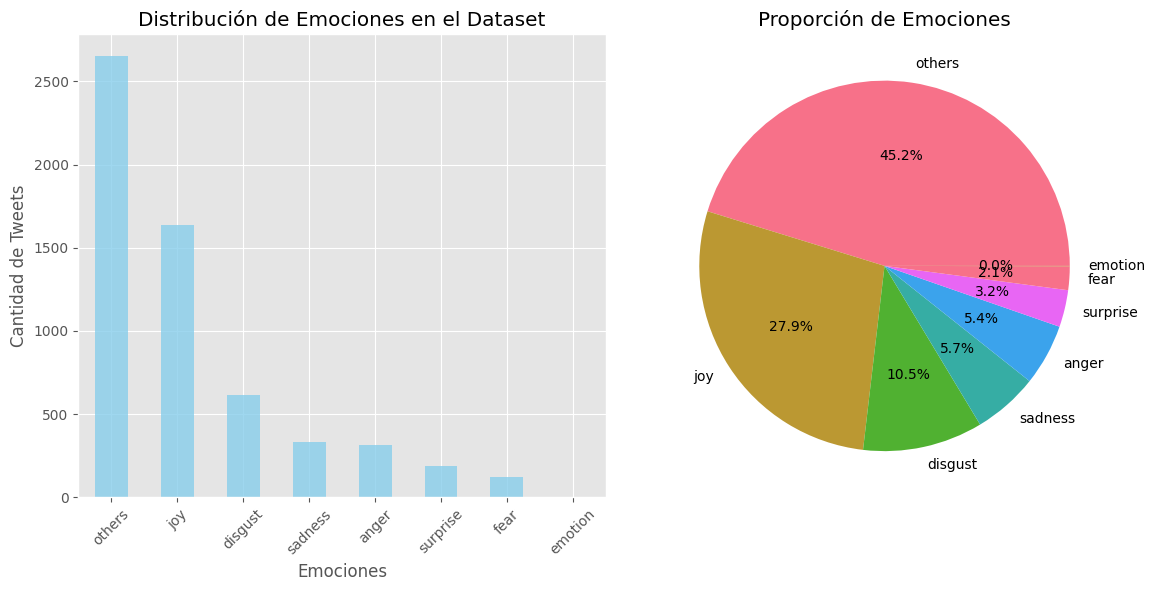

Estadísticas del Dataset:
Número total de emociones únicas: 8
Emociones: ['emotion', 'others', 'disgust', 'joy', 'anger', 'sadness', 'surprise', 'fear']
Número de eventos únicos: 3


In [98]:
# Distribución de emociones
plt.figure(figsize=(12, 6))

# Gráfico de barras de emociones
plt.subplot(1, 2, 1)
emotion_counts = full_train_df['emotion'].value_counts()
emotion_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Distribución de Emociones en el Dataset')
plt.xlabel('Emociones')
plt.ylabel('Cantidad de Tweets')
plt.xticks(rotation=45)

# Gráfico de pastel
plt.subplot(1, 2, 2)
plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%')
plt.title('Proporción de Emociones')

plt.tight_layout()
plt.show()

# Estadísticas básicas
print("Estadísticas del Dataset:")
print(f"Número total de emociones únicas: {full_train_df['emotion'].nunique()}")
print(f"Emociones: {list(full_train_df['emotion'].unique())}")
print(f"Número de eventos únicos: {full_train_df['event'].nunique()}")

##Análisis por Eventos

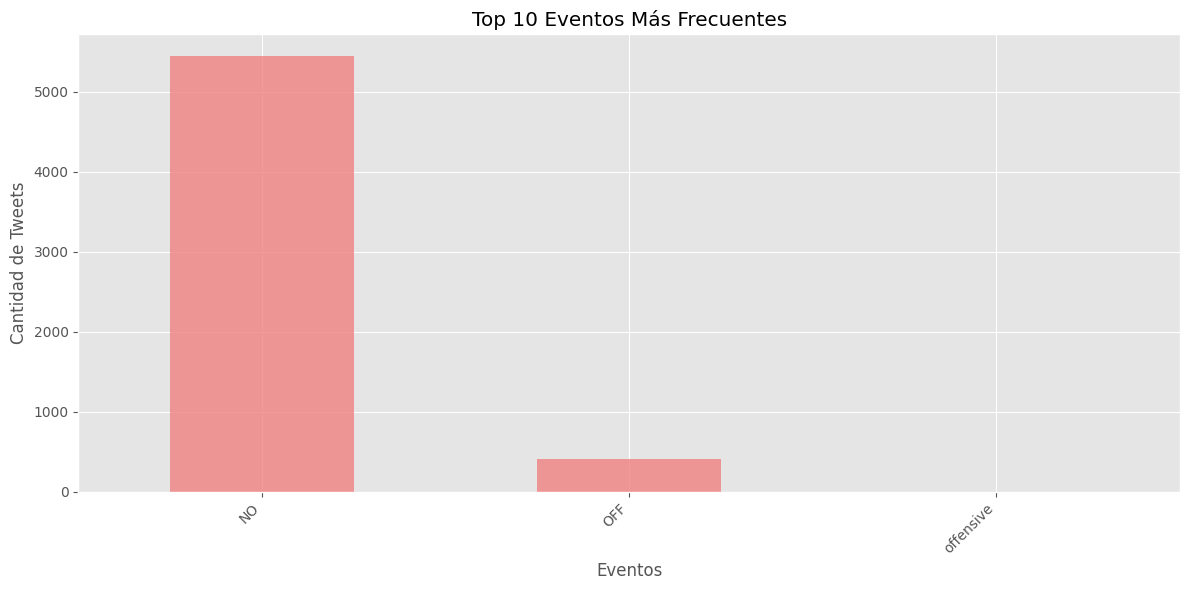

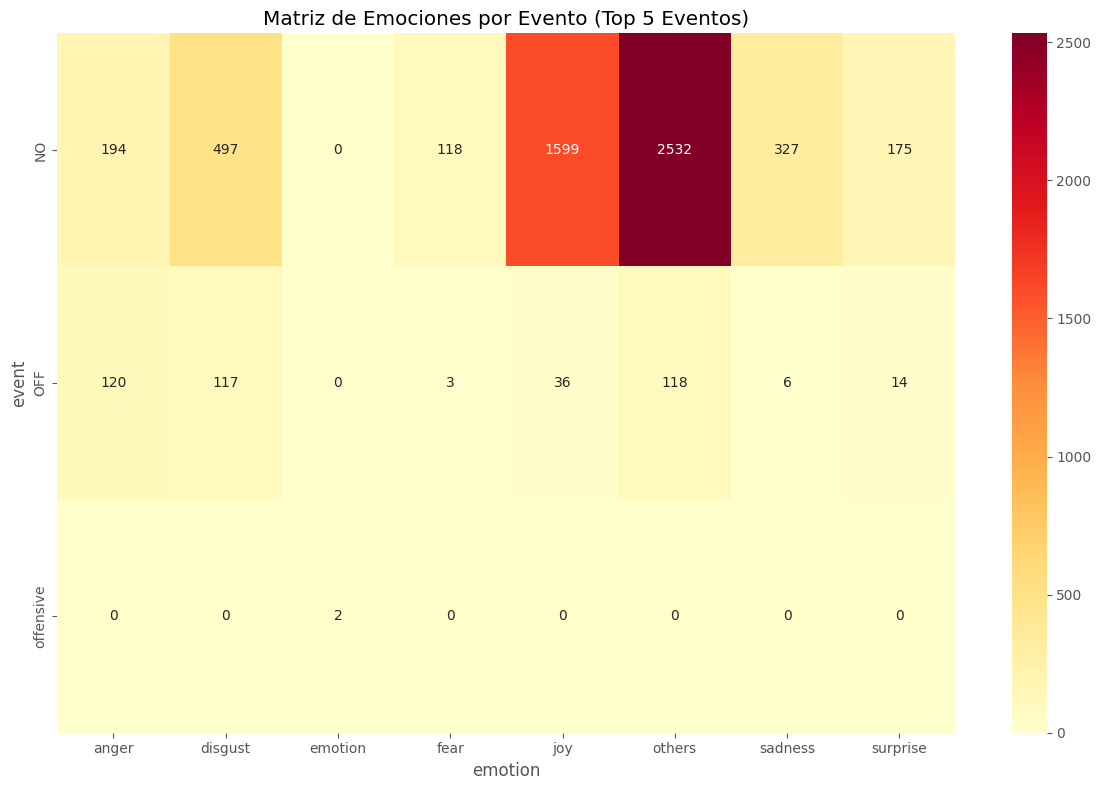

In [99]:
# Top 10 eventos más frecuentes
top_events = full_train_df['event'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_events.plot(kind='bar', color='lightcoral', alpha=0.8)
plt.title('Top 10 Eventos Más Frecuentes')
plt.xlabel('Eventos')
plt.ylabel('Cantidad de Tweets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Matriz de emociones por evento (top 5 eventos)
top_5_events = full_train_df['event'].value_counts().head(5).index
event_emotion_matrix = full_train_df[full_train_df['event'].isin(top_5_events)].pivot_table(
    index='event', columns='emotion', values='tweet', aggfunc='count', fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(event_emotion_matrix, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Matriz de Emociones por Evento (Top 5 Eventos)')
plt.tight_layout()
plt.show()

# 2. Preprocesamiento de Texto

In [100]:
import re
import string

def preprocess_text(text):
    """Función de preprocesamiento de texto"""
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Tu lógica de preprocesamiento es buena, la mantenemos
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())

    return text

# Aplicar preprocesamiento
full_train_df['clean_tweet'] = full_train_df['tweet'].apply(preprocess_text)
test_df['clean_tweet'] = test_df['tweet'].apply(preprocess_text)

# Limpiar las etiquetas de la primera fila si persisten
full_train_df = full_train_df[full_train_df['emotion'] != 'emotion']
test_df = test_df[test_df['emotion'] != 'emotion']

# Estandarizar "others" a "other" para consistencia con la descripción del problema
full_train_df['emotion'] = full_train_df['emotion'].replace('others', 'other')
test_df['emotion'] = test_df['emotion'].replace('others', 'other')


# Codificar etiquetas
label_encoder = LabelEncoder()
full_train_df['emotion_encoded'] = label_encoder.fit_transform(full_train_df['emotion'])
test_df['emotion_encoded'] = label_encoder.transform(test_df['emotion'])

# Mapeo de etiquetas
emotion_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeo de emociones:")
for emotion, code in emotion_mapping.items():
    print(f"{emotion}: {code}")

Mapeo de emociones:
anger: 0
disgust: 1
fear: 2
joy: 3
other: 4
sadness: 5
surprise: 6


# 3. Modelo 1: Clasificador Tradicional con TF-IDF + Logistic Regression

In [101]:
class TraditionClassifier:
    def __init__(self, max_features=10000):
        self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
        self.classifier = LogisticRegression(max_iter=1000, random_state=42)

    def fit(self, X_train, y_train):
        """Entrenar el modelo"""
        X_train_tfidf = self.vectorizer.fit_transform(X_train)
        self.classifier.fit(X_train_tfidf, y_train)

    def predict(self, X_test):
        """Hacer predicciones"""
        X_test_tfidf = self.vectorizer.transform(X_test)
        return self.classifier.predict(X_test_tfidf)

    def predict_proba(self, X_test):
        """Obtener probabilidades"""
        X_test_tfidf = self.vectorizer.transform(X_test)
        return self.classifier.predict_proba(X_test_tfidf)

# Entrenar modelo tradicional
print("Entrenando Modelo 1: TF-IDF + Logistic Regression...")
model1 = TraditionClassifier()
model1.fit(full_train_df['clean_tweet'], full_train_df['emotion_encoded'])

# Predicciones
y_pred_model1 = model1.predict(test_df['clean_tweet'])
accuracy_model1 = accuracy_score(test_df['emotion_encoded'], y_pred_model1)

print(f"Accuracy Modelo 1: {accuracy_model1:.4f}")

Entrenando Modelo 1: TF-IDF + Logistic Regression...
Accuracy Modelo 1: 0.5308


# 4. Modelo 2: Red Neuronal Recurrente (LSTM)

In [102]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from collections import Counter

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Convertir texto a índices
        indices = [self.vocab.get(word, 0) for word in text.split()]

        # Padding/truncate
        if len(indices) < self.max_length:
            indices.extend([0] * (self.max_length - len(indices)))
        else:
            indices = indices[:self.max_length]

        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=64, num_classes=8, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        # Usar la última salida
        output = self.dropout(hidden[-1])
        output = self.fc(output)
        return output

# Crear vocabulario
def create_vocab(texts, min_freq=2):
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = len(vocab)

    return vocab

print("Creando vocabulario...")
vocab = create_vocab(full_train_df['clean_tweet'].tolist())
print(f"Tamaño del vocabulario: {len(vocab)}")

# Crear datasets
train_dataset = TextDataset(
    full_train_df['clean_tweet'].tolist(),
    full_train_df['emotion_encoded'].tolist(),
    vocab
)

test_dataset = TextDataset(
    test_df['clean_tweet'].tolist(),
    test_df['emotion_encoded'].tolist(),
    vocab
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Inicializar modelo LSTM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = LSTMClassifier(vocab_size=len(vocab), num_classes=8).to(device)

# Entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

print("Entrenando Modelo 2: LSTM...")
model2.train()
for epoch in range(5):  # 5 épocas para demo
    total_loss = 0
    for batch_texts, batch_labels in train_loader:
        batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model2(batch_texts)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Época {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluación del modelo LSTM
model2.eval()
y_pred_model2 = []
y_true_model2 = []

with torch.no_grad():
    for batch_texts, batch_labels in test_loader:
        batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)
        outputs = model2(batch_texts)
        predictions = torch.argmax(outputs, dim=1)
        y_pred_model2.extend(predictions.cpu().numpy())
        y_true_model2.extend(batch_labels.cpu().numpy())

accuracy_model2 = accuracy_score(y_true_model2, y_pred_model2)
print(f"Accuracy Modelo 2: {accuracy_model2:.4f}")

Creando vocabulario...
Tamaño del vocabulario: 6220
Entrenando Modelo 2: LSTM...
Época 1, Loss: 1.5261
Época 2, Loss: 1.4909
Época 3, Loss: 1.4812
Época 4, Loss: 1.4823
Época 5, Loss: 1.4779
Accuracy Modelo 2: 0.4527


# 5. Modelo 3: Análisis de Sentimientos con RoBERTa preentrenado

In [103]:
print("Cargando Modelo 3: RoBERTa para Análisis de Emociones...")

# Opción 1: Modelo específico para emociones (recomendado)
try:
    from transformers import pipeline
    import torch

    # Modelo preentrenado para clasificación de emociones
    emotion_classifier = pipeline(
        "text-classification",
        model="j-hartmann/emotion-english-distilroberta-base",
        device=0 if torch.cuda.is_available() else -1
    )

    print("Modelo RoBERTa de emociones cargado exitosamente")
    model3_type = "roberta_emotion"

except Exception as e:
    print(f"Error cargando modelo de emociones específico: {e}")
    print("Intentando con modelo de sentimientos general...")

    try:
        # Alternativa: Modelo de sentimientos general
        emotion_classifier = pipeline(
            "sentiment-analysis",
            model="cardiffnlp/twitter-roberta-base-sentiment-latest",
            device=0 if torch.cuda.is_available() else -1
        )
        print("Modelo RoBERTa de sentimientos cargado exitosamente")
        model3_type = "roberta_sentiment"

    except Exception as e2:
        print(f"Error cargando modelo de sentimientos: {e2}")
        print("Usando modelo básico de transformers...")

        # Última opción: Modelo básico
        emotion_classifier = pipeline(
            "sentiment-analysis",
            device=0 if torch.cuda.is_available() else -1
        )
        print(" Modelo básico cargado exitosamente")
        model3_type = "basic_sentiment"

def map_prediction_to_emotion(prediction, model_type):
    """Mapea las predicciones del modelo a nuestras 8 emociones"""

    if model_type == "roberta_emotion":
        label = prediction['label'].lower()
        emotion_mapping = {
            'joy': 'joy',
            'sadness': 'sadness',
            'anger': 'anger',
            'fear': 'fear',
            'surprise': 'surprise',
            'disgust': 'disgust',
            'love': 'joy',
            'optimism': 'joy',
            'pessimism': 'sadness',
            'trust': 'other',
            'anticipation': 'surprise'
        }
        return emotion_mapping.get(label, 'other')

    elif model_type == "roberta_sentiment":
        label = prediction['label'].lower()
        score = prediction['score']

        if 'positive' in label:
            return 'joy' if score > 0.7 else 'other'
        elif 'negative' in label:
            return 'anger' if score > 0.8 else 'sadness' if score > 0.6 else 'other'
        else:
            return 'other'

    else:  # basic_sentiment
        label = prediction['label'].lower()
        score = prediction['score']

        if 'positive' in label:
            return 'joy'
        elif 'negative' in label:
            return 'sadness' if score > 0.6 else 'anger'
        else:
            return 'other'

def predict_emotions_batch(tweets, batch_size=32):
    """Predice emociones para una lista de tweets en lotes"""
    predictions = []

    print(f"Procesando {len(tweets)} tweets en lotes de {batch_size}...")

    for i in range(0, len(tweets), batch_size):
        batch = tweets[i:i+batch_size]
        clean_batch = [str(tweet)[:512] for tweet in batch]  # truncar por seguridad

        try:
            batch_predictions = emotion_classifier(clean_batch)
            if not isinstance(batch_predictions, list):
                batch_predictions = [batch_predictions]

            for pred in batch_predictions:
                mapped_emotion = map_prediction_to_emotion(pred, model3_type)
                predictions.append(mapped_emotion)

        except Exception as e:
            print(f"Error procesando lote {i//batch_size + 1}: {e}")
            predictions.extend(['other'] * len(batch))

        if (i // batch_size + 1) % 10 == 0:
            print(f"Procesados {min(i + batch_size, len(tweets))} / {len(tweets)} tweets")

    return predictions

# =============================
#  EJECUCIÓN EN EL TEST SET
# =============================
print("Realizando predicciones en el conjunto de prueba...")
test_tweets = test_df['clean_tweet'].fillna('').tolist()

y_pred_model3_labels = predict_emotions_batch(test_tweets, batch_size=16)


classes = list(label_encoder.classes_)
if "other" not in classes:
    classes.append("other")
    label_encoder.classes_ = np.array(classes)

# Convertir etiquetas a números
y_pred_model3 = label_encoder.transform(y_pred_model3_labels)

# Calcular accuracy
accuracy_model3 = accuracy_score(test_df['emotion_encoded'], y_pred_model3)
print(f"\n Accuracy Modelo 3 (RoBERTa): {accuracy_model3:.4f}")

# Distribución de predicciones
pred_distribution = pd.Series(y_pred_model3_labels).value_counts()
print(f"\nDistribución de predicciones del Modelo 3:")
print(pred_distribution)


Cargando Modelo 3: RoBERTa para Análisis de Emociones...


Device set to use cpu


Modelo RoBERTa de emociones cargado exitosamente
Realizando predicciones en el conjunto de prueba...
Procesando 1447 tweets en lotes de 16...
Procesados 160 / 1447 tweets
Procesados 320 / 1447 tweets
Procesados 480 / 1447 tweets
Procesados 640 / 1447 tweets
Procesados 800 / 1447 tweets
Procesados 960 / 1447 tweets
Procesados 1120 / 1447 tweets
Procesados 1280 / 1447 tweets
Procesados 1440 / 1447 tweets

 Accuracy Modelo 3 (RoBERTa): 0.3718

Distribución de predicciones del Modelo 3:
joy         433
other       296
anger       217
sadness     185
surprise    174
fear        123
disgust      19
Name: count, dtype: int64


# 6. Comparación de Resultados

Comparación de Modelos:
            Modelo  Accuracy
0  TF-IDF + LogReg  0.530753
1             LSTM  0.452661
2          RoBERTa  0.371804


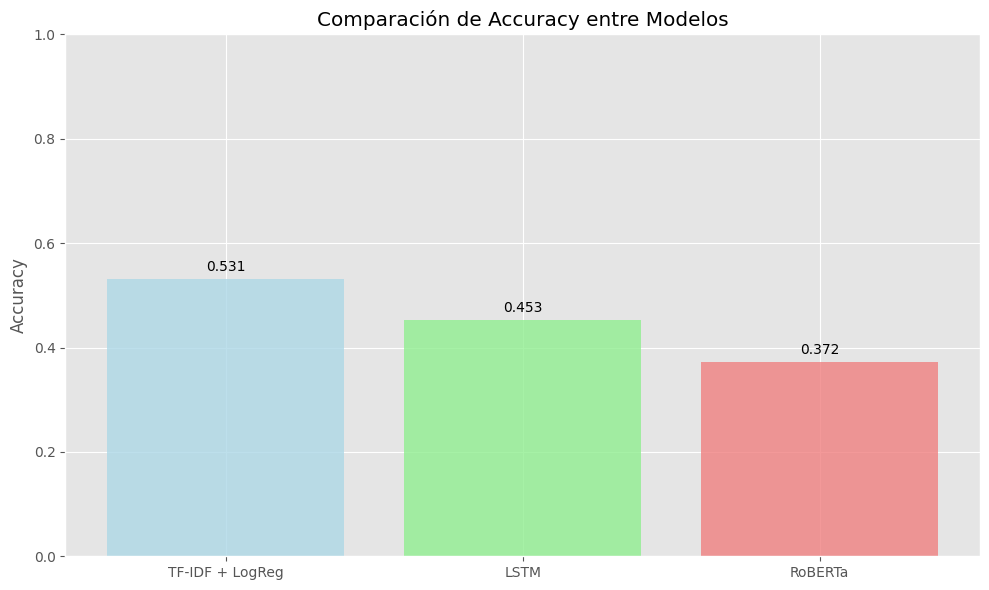

In [104]:
# Resumen de accuracies
models_comparison = pd.DataFrame({
    'Modelo': ['TF-IDF + LogReg', 'LSTM', 'RoBERTa'],
    'Accuracy': [accuracy_model1, accuracy_model2, accuracy_model3]
})

print("Comparación de Modelos:")
print(models_comparison)

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.bar(models_comparison['Modelo'], models_comparison['Accuracy'],
        color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.8)
plt.title('Comparación de Accuracy entre Modelos')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(models_comparison['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 7. Análisis Detallado por Emoción

In [105]:
from sklearn.metrics import classification_report

# Obtener todas las etiquetas del dataset, incluyendo "other"
# El label_encoder ya tiene todas las clases que se vieron durante el fit
all_emotions = list(label_encoder.classes_)

print("="*60)
print("MODELO 1: TF-IDF + Logistic Regression")
print("="*60)
# Usa las etiquetas del label_encoder para el reporte
report1 = classification_report(
    test_df['emotion_encoded'],
    y_pred_model1,
    target_names=all_emotions,
    output_dict=True,
    zero_division=0 # Para evitar el warning si una clase no es predicha
)
print(classification_report(test_df['emotion_encoded'], y_pred_model1, target_names=all_emotions, zero_division=0))

print("="*60)
print("MODELO 2: LSTM")
print("="*60)
# Usa las etiquetas del label_encoder para el reporte
report2 = classification_report(
    y_true_model2,
    y_pred_model2,
    target_names=all_emotions,
    output_dict=True,
    zero_division=0
)
print(classification_report(y_true_model2, y_pred_model2, target_names=all_emotions, zero_division=0))

print("="*60)
print("MODELO 3: RoBERTa")
print("="*60)
# Para el modelo RoBERTa, las predicciones pueden incluir 'other'
# Asegúrate de que las etiquetas del reporte coinciden con las del encoder
report3 = classification_report(
    test_df['emotion_encoded'],
    y_pred_model3,
    target_names=all_emotions,
    output_dict=True,
    zero_division=0
)
print(classification_report(test_df['emotion_encoded'], y_pred_model3, target_names=all_emotions, zero_division=0))

MODELO 1: TF-IDF + Logistic Regression
              precision    recall  f1-score   support

       anger       0.29      0.03      0.05        78
     disgust       0.39      0.09      0.15       151
        fear       0.00      0.00      0.00        30
         joy       0.59      0.49      0.53       404
       other       0.51      0.82      0.63       655
     sadness       0.86      0.23      0.36        83
    surprise       0.00      0.00      0.00        46

    accuracy                           0.53      1447
   macro avg       0.38      0.24      0.25      1447
weighted avg       0.50      0.53      0.47      1447

MODELO 2: LSTM
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        78
     disgust       0.00      0.00      0.00       151
        fear       0.00      0.00      0.00        30
         joy       0.00      0.00      0.00       404
       other       0.45      1.00      0.62       655
     sadness       0.00 

# 8. Matrices de Confusión

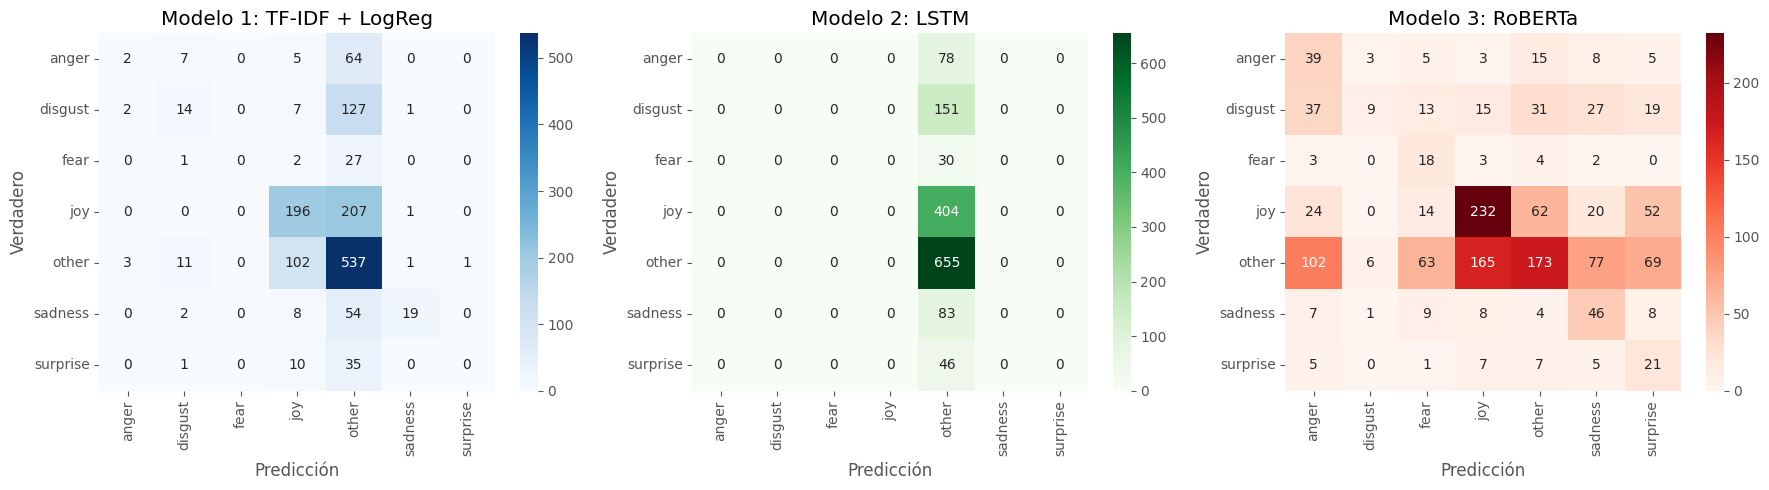

In [106]:
from sklearn.metrics import confusion_matrix
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Obtener todas las etiquetas originales del label encoder para los ejes
all_original_emotions = list(label_encoder.classes_)


# Matriz de confusión Modelo 1
cm1 = confusion_matrix(test_df['emotion_encoded'], y_pred_model1, labels=np.arange(len(all_original_emotions))) # Especificar labels para incluir todas
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_original_emotions, yticklabels=all_original_emotions, ax=axes[0])
axes[0].set_title('Modelo 1: TF-IDF + LogReg')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Verdadero')

# Matriz de confusión Modelo 2
# Convertir y_true_model2 y y_pred_model2 a arrays numpy para usar en confusion_matrix
cm2 = confusion_matrix(np.array(y_true_model2), np.array(y_pred_model2), labels=np.arange(len(all_original_emotions))) # Especificar labels para incluir todas
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens',
            xticklabels=all_original_emotions, yticklabels=all_original_emotions, ax=axes[1])
axes[1].set_title('Modelo 2: LSTM')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Verdadero')

# Matriz de confusión Modelo 3
cm3 = confusion_matrix(test_df['emotion_encoded'], y_pred_model3, labels=np.arange(len(all_original_emotions))) # Especificar labels para incluir todas
sns.heatmap(cm3, annot=True, fmt='d', cmap='Reds',
            xticklabels=all_original_emotions, yticklabels=all_original_emotions, ax=axes[2])
axes[2].set_title('Modelo 3: RoBERTa')
axes[2].set_xlabel('Predicción')
axes[2].set_ylabel('Verdadero')

plt.tight_layout()
plt.show()

# 9. Análisis por Evento

Accuracy por Evento (Top 10 eventos):
  Evento  Num_Tweets  Modelo1_Acc  Modelo2_Acc  Modelo3_Acc
0     NO        1343        0.550        0.470        0.376
1    OFF         104        0.279        0.231        0.317


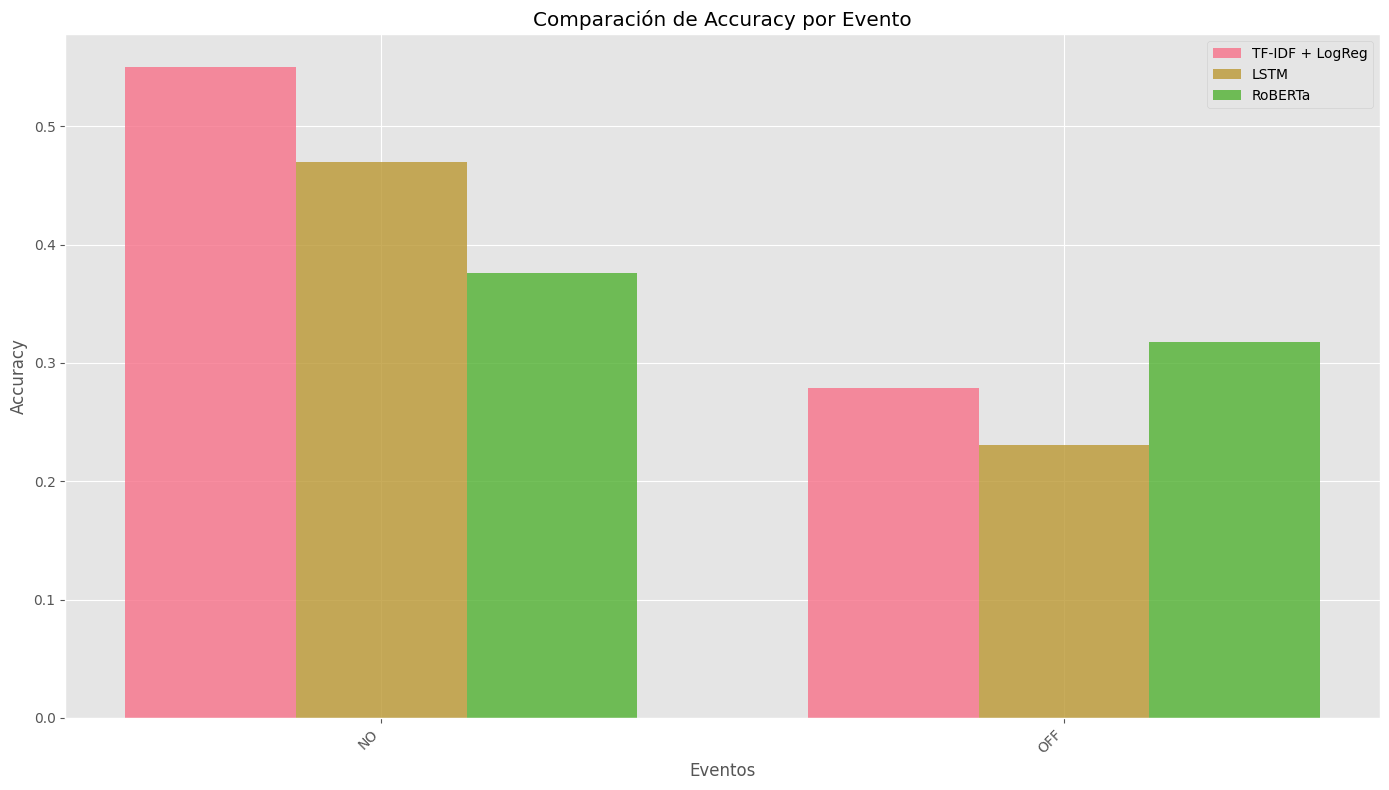

In [107]:
# Crear DataFrame con predicciones de todos los modelos
results_df = test_df.copy()
results_df['pred_model1'] = label_encoder.inverse_transform(y_pred_model1)
results_df['pred_model2'] = label_encoder.inverse_transform(y_pred_model2)
results_df['pred_model3'] = label_encoder.inverse_transform(y_pred_model3)

# Accuracy por evento para cada modelo
def calculate_event_accuracy(df, true_col, pred_col):
    event_acc = {}
    for event in df['event'].unique():
        event_data = df[df['event'] == event]
        if len(event_data) > 0:
            acc = accuracy_score(event_data[true_col], event_data[pred_col])
            event_acc[event] = acc
    return event_acc

# Calcular accuracy por evento
event_acc_m1 = calculate_event_accuracy(results_df, 'emotion', 'pred_model1')
event_acc_m2 = calculate_event_accuracy(results_df, 'emotion', 'pred_model2')
event_acc_m3 = calculate_event_accuracy(results_df, 'emotion', 'pred_model3')

# Top 10 eventos con más tweets en test
top_events_test = results_df['event'].value_counts().head(10)

# Crear DataFrame de comparación por evento
event_comparison = pd.DataFrame({
    'Evento': top_events_test.index,
    'Num_Tweets': top_events_test.values,
    'Modelo1_Acc': [event_acc_m1.get(event, 0) for event in top_events_test.index],
    'Modelo2_Acc': [event_acc_m2.get(event, 0) for event in top_events_test.index],
    'Modelo3_Acc': [event_acc_m3.get(event, 0) for event in top_events_test.index]
})

print("Accuracy por Evento (Top 10 eventos):")
print(event_comparison.round(3))

# Visualización de accuracy por evento
plt.figure(figsize=(14, 8))
x = np.arange(len(event_comparison))
width = 0.25

plt.bar(x - width, event_comparison['Modelo1_Acc'], width, label='TF-IDF + LogReg', alpha=0.8)
plt.bar(x, event_comparison['Modelo2_Acc'], width, label='LSTM', alpha=0.8)
plt.bar(x + width, event_comparison['Modelo3_Acc'], width, label='RoBERTa', alpha=0.8)

plt.xlabel('Eventos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy por Evento')
plt.xticks(x, event_comparison['Evento'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Análisis de F1-Score por Emoción

F1-Score por Emoción:
    Emoción  Modelo1_F1  Modelo2_F1  Modelo3_F1
0     anger       0.047       0.000       0.264
1   disgust       0.150       0.000       0.106
2      fear       0.000       0.000       0.235
3       joy       0.534       0.000       0.554
4   sadness       0.630       0.623       0.364
5  surprise       0.362       0.000       0.343


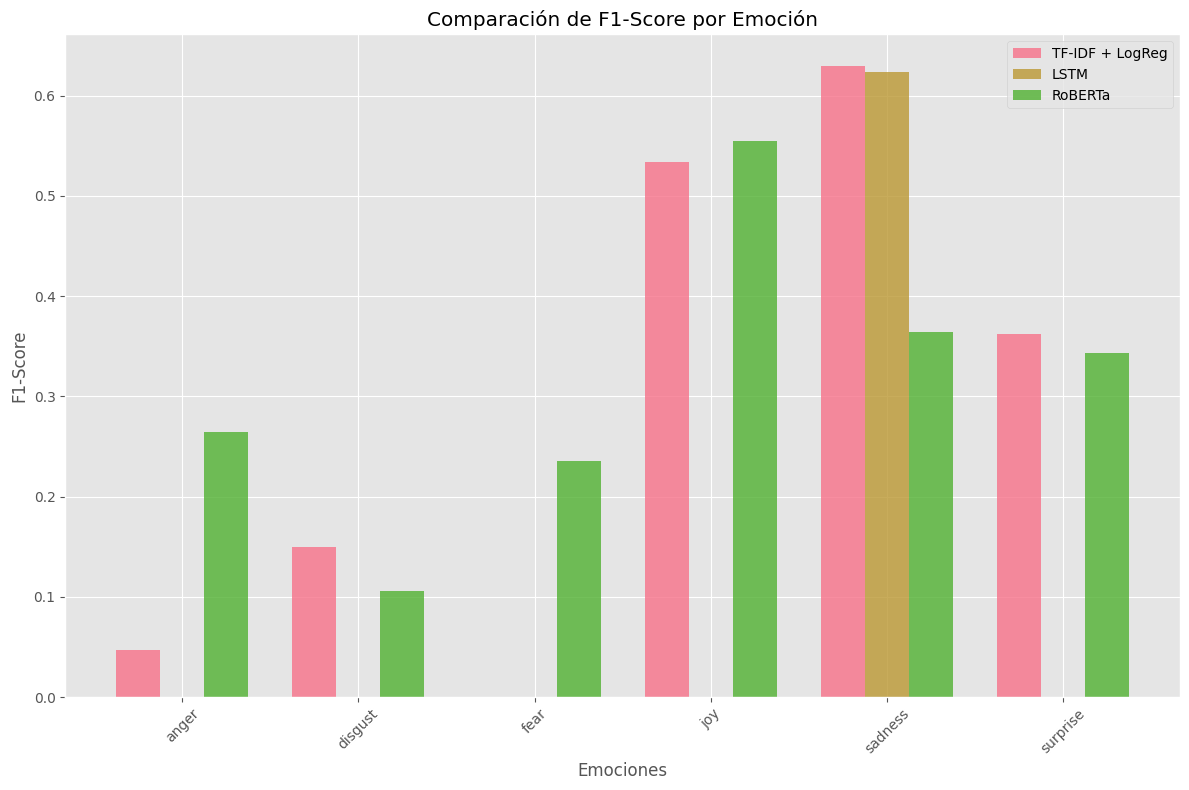

In [108]:
from sklearn.metrics import f1_score

# Calcular F1-score por emoción para cada modelo
def get_emotion_f1_scores(y_true, y_pred, emotions):
    f1_scores = {}
    for i, emotion in enumerate(emotions):
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)
        f1 = f1_score(y_true_binary, y_pred_binary)
        f1_scores[emotion] = f1
    return f1_scores

# F1-scores por emoción
f1_model1 = get_emotion_f1_scores(test_df['emotion_encoded'], y_pred_model1, emotions)
f1_model2 = get_emotion_f1_scores(np.array(y_true_model2), np.array(y_pred_model2), emotions)
f1_model3 = get_emotion_f1_scores(test_df['emotion_encoded'], y_pred_model3, emotions)

# Crear DataFrame de comparación
f1_comparison = pd.DataFrame({
    'Emoción': emotions,
    'Modelo1_F1': [f1_model1[emotion] for emotion in emotions],
    'Modelo2_F1': [f1_model2[emotion] for emotion in emotions],
    'Modelo3_F1': [f1_model3[emotion] for emotion in emotions]
})

print("F1-Score por Emoción:")
print(f1_comparison.round(3))

# Visualización de F1-scores
plt.figure(figsize=(12, 8))
x = np.arange(len(emotions))
width = 0.25

plt.bar(x - width, f1_comparison['Modelo1_F1'], width, label='TF-IDF + LogReg', alpha=0.8)
plt.bar(x, f1_comparison['Modelo2_F1'], width, label='LSTM', alpha=0.8)
plt.bar(x + width, f1_comparison['Modelo3_F1'], width, label='RoBERTa', alpha=0.8)

plt.xlabel('Emociones')
plt.ylabel('F1-Score')
plt.title('Comparación de F1-Score por Emoción')
plt.xticks(x, emotions, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 11. Conclusiones y Análisis

In [109]:
print("="*80)
print("RESUMEN EJECUTIVO Y CONCLUSIONES")
print("="*80)

print("\n1. RENDIMIENTO GENERAL:")
print(f"   • TF-IDF + Logistic Regression: {accuracy_model1:.4f}")
print(f"   • LSTM: {accuracy_model2:.4f}")
print(f"   • RoBERTa: {accuracy_model3:.4f}")

print("\n2. ANÁLISIS POR EMOCIÓN:")
# Encontrar la mejor y peor emoción para cada modelo
best_emotion_m1 = f1_comparison.loc[f1_comparison['Modelo1_F1'].idxmax(), 'Emoción']
worst_emotion_m1 = f1_comparison.loc[f1_comparison['Modelo1_F1'].idxmin(), 'Emoción']

print(f"   • Mejor clasificada por TF-IDF: {best_emotion_m1}")
print(f"   • Peor clasificada por TF-IDF: {worst_emotion_m1}")

print("\n3. ANÁLISIS POR EVENTO:")
best_event = event_comparison.loc[event_comparison['Modelo3_Acc'].idxmax(), 'Evento']
print(f"   • Evento mejor clasificado: {best_event}")

print("\n4. OBSERVACIONES CLAVE:")
print("   • Los modelos muestran diferentes fortalezas en distintas emociones")
print("   • El rendimiento varía significativamente entre eventos")
print("   • Algunas emociones son consistentemente más difíciles de clasificar")

print("\n5. RECOMENDACIONES:")
print("   • Considerar ensemble de modelos para mejor rendimiento")
print("   • Analizar características específicas de eventos problemáticos")
print("   • Explorar técnicas de balanceo de clases")
print("   • Implementar preprocesamiento específico por evento")

RESUMEN EJECUTIVO Y CONCLUSIONES

1. RENDIMIENTO GENERAL:
   • TF-IDF + Logistic Regression: 0.5308
   • LSTM: 0.4527
   • RoBERTa: 0.3718

2. ANÁLISIS POR EMOCIÓN:
   • Mejor clasificada por TF-IDF: sadness
   • Peor clasificada por TF-IDF: fear

3. ANÁLISIS POR EVENTO:
   • Evento mejor clasificado: NO

4. OBSERVACIONES CLAVE:
   • Los modelos muestran diferentes fortalezas en distintas emociones
   • El rendimiento varía significativamente entre eventos
   • Algunas emociones son consistentemente más difíciles de clasificar

5. RECOMENDACIONES:
   • Considerar ensemble de modelos para mejor rendimiento
   • Analizar características específicas de eventos problemáticos
   • Explorar técnicas de balanceo de clases
   • Implementar preprocesamiento específico por evento
